# Проект: классификация

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [4]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?

display(df.sample(3))
display(df.info())
df.isnull().sum()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2300,31,technician,single,tertiary,no,"252,00 $",no,no,cellular,8,jun,107,3,-1,0,unknown,yes
2298,36,services,married,primary,no,"92,00 $",yes,no,cellular,5,jun,244,7,-1,0,unknown,yes
3322,34,management,married,tertiary,no,"158,00 $",no,no,cellular,9,mar,212,3,181,6,success,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

,0
age,0
job,0
marital,0
education,0
default,0
balance,25
housing,0
loan,0
contact,0
day,0


### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

,count
job,
management,2566
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357


### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_to_float(x):
    x = str(x)
    return float(x.split(',')[0].replace(' ', '').replace('$', ''))

df['balance'] = df['balance'].apply(balance_to_float)


### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df.loc[df['balance'].isnull(), 'balance'] = df['balance'].median()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        11162 non-null  int64  
 1   job        11162 non-null  object 
 2   marital    11162 non-null  object 
 3   education  11162 non-null  object 
 4   default    11162 non-null  object 
 5   balance    11162 non-null  float64
 6   housing    11162 non-null  object 
 7   loan       11162 non-null  object 
 8   contact    11162 non-null  object 
 9   day        11162 non-null  int64  
 10  month      11162 non-null  object 
 11  duration   11162 non-null  int64  
 12  campaign   11162 non-null  int64  
 13  pdays      11162 non-null  int64  
 14  previous   11162 non-null  int64  
 15  poutcome   11162 non-null  object 
 16  deposit    11162 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


In [9]:
df['job'].value_counts()

,count
job,
management,2566
blue-collar,1944
technician,1823
admin.,1334
services,923
retired,778
self-employed,405
student,360
unemployed,357


### Задание 5

In [10]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

df.loc[df['job'] == 'unknown', 'job'] = df['job'].mode()[0]
df.loc[df['education'] == 'unknown', 'education'] = df['education'].mode()[0]

# np.round(df[(df['job'] == df['job'].value_counts().reset_index()['job'][0]) & (df['education'] == df['education'].value_counts().reset_index()['education'][0])]['balance'].mean(), 3)



### Задание 6

In [11]:
# удалите все выбросы для признака balance

columns = df.columns

def tyuki(df, col):
   x = df[col]
   q1 = x.quantile(0.25)
   q3 = x.quantile(0.75)
   iqr = q3 - q1
   lower = q1- 1.5*iqr
   higher = q3 + 1.5*iqr
   outliers = df[(x < (lower)) | (x > (higher))]
   cleaned = df[(x >= (lower)) & (x <= (higher))]
   return cleaned, outliers, lower, higher


cleaned, outliers, lower, higher  = tyuki(df, 'balance')

print("Outliers count:", len(outliers))
print("Cleaned count:", len(cleaned))
print("Lower bound:", lower)
print("Upper bound:", higher)

df = cleaned

# df = pd.DataFrame(cleaned, columns=columns)
# df


Outliers count: 1057
Cleaned count: 10105
Lower bound: -2241.0
Upper bound: 4063.0


## Часть 2:  Разведывательный анализ

### Задание 1

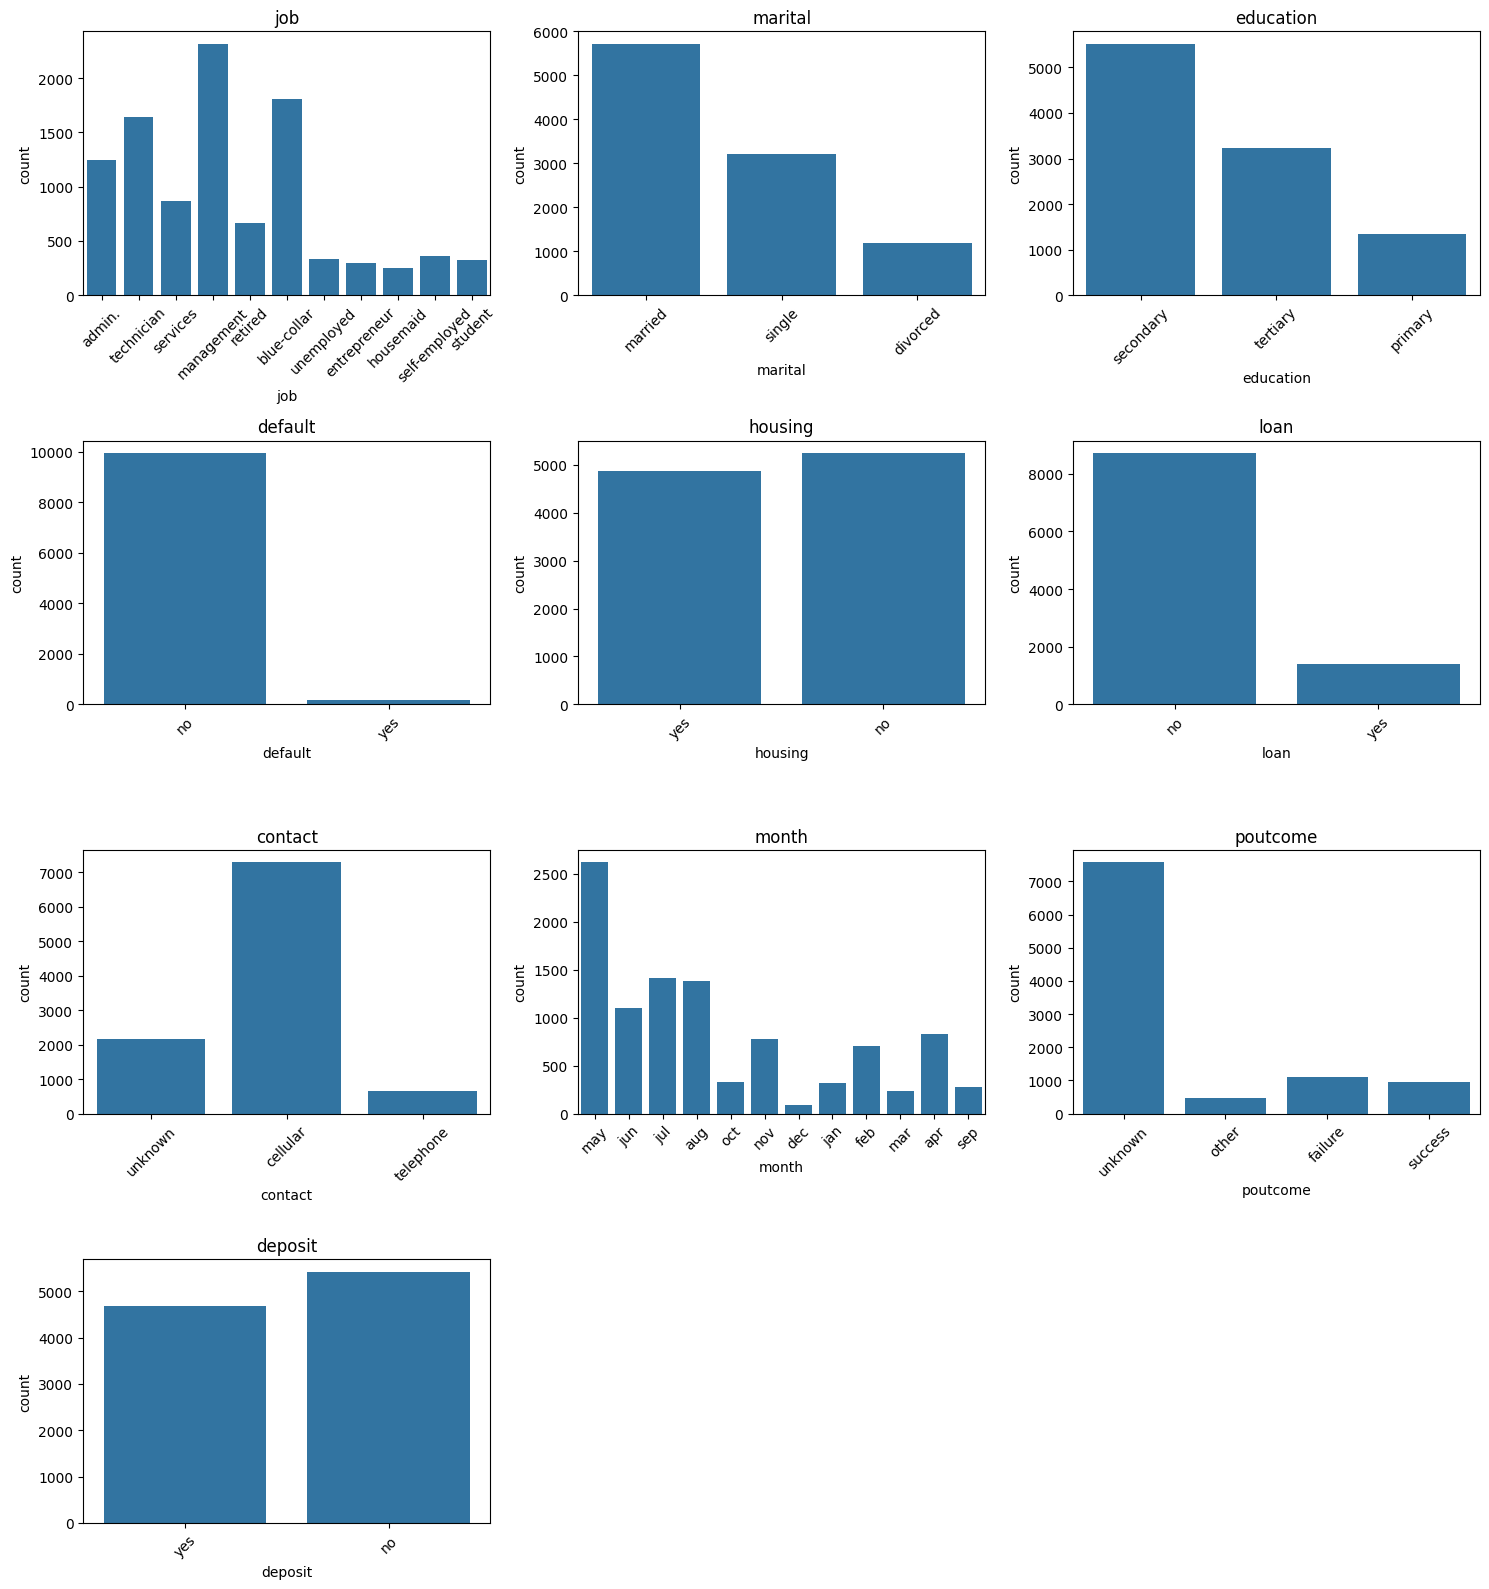

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
objects = [x for x in df.columns if df[x].dtype == 'object']
n_cols = 3
n_rows = (len(objects) + n_cols - 1) // n_cols  # округление вверх

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten()  # чтобы удобно итерировать

for i, col in enumerate(objects):
    sns.countplot(x=col, data=df, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=45)

# Отключим пустые графики (если столбцов < n_rows * n_cols)
for j in range(len(objects), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Задания 2 и 3

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код

### Задания 4 и 5

In [14]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты

### Задание 6

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: count, dtype: int64

### Задание 7

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код

df.groupby('month')['deposit'].value_counts()

month  deposit
apr    yes         513
       no          317
aug    no          775
       yes         610
dec    yes          84
       no            9
feb    yes         386
       no          323
jan    no          194
       yes         125
jul    no          836
       yes         582
jun    no          606
       yes         498
mar    yes         213
       no           24
may    no         1776
       yes         841
nov    no          456
       yes         324
oct    yes         273
       no           62
sep    yes         232
       no           46
Name: count, dtype: int64

### Задание 8

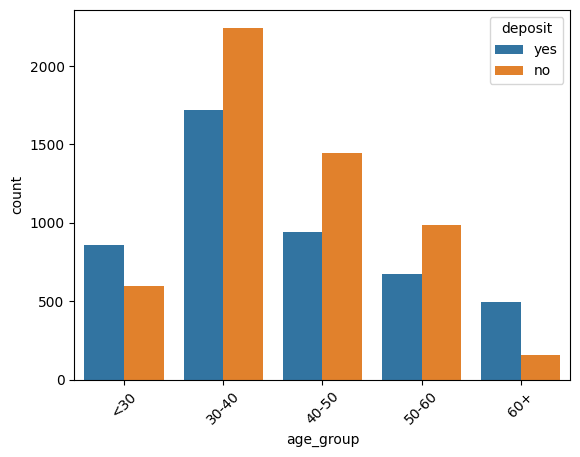

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

age_df = df.copy()

bins = [0, 30, 40, 50, 60, float('inf')]
labels = ['<30', '30-40', '40-50', '50-60', '60+']

age_df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


sns.countplot(x='age_group', hue='deposit', data=age_df)
plt.tick_params(axis='x', rotation=45)
plt.show()

### Задания 9 и 10

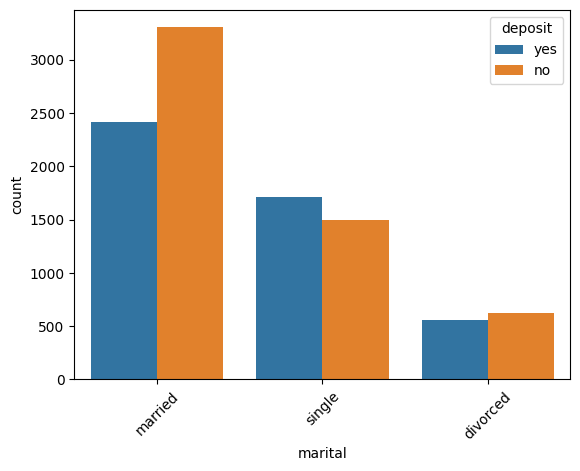

In [18]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.countplot(x='marital', hue='deposit', data=df)
plt.tick_params(axis='x', rotation=45)
plt.show()

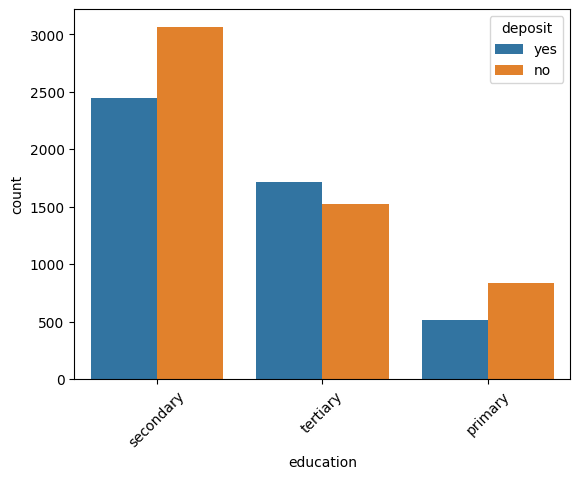

In [19]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

sns.countplot(x='education', hue='deposit', data=df)
plt.tick_params(axis='x', rotation=45)
plt.show()

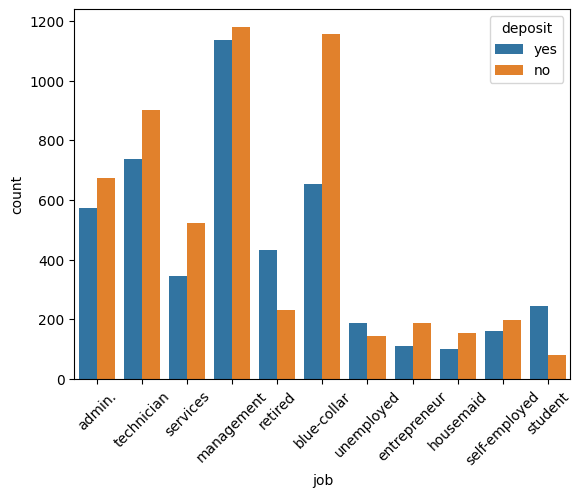

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(x='job', hue='deposit', data=df)
plt.tick_params(axis='x', rotation=45)
plt.show()

### Задание 11

In [21]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

df.groupby(['education', 'marital'])['deposit'].value_counts()



education  marital   deposit
primary    divorced  yes          96
                     no           91
           married   no          641
                     yes         339
           single    no          100
                     yes          82
secondary  divorced  no          370
                     yes         283
           married   no         1830
                     yes        1289
           single    yes         879
                     no          866
tertiary   divorced  yes         174
                     no          163
           married   no          832
                     yes         784
           single    yes         755
                     no          531
Name: count, dtype: int64

## Часть 3: преобразование данных

### Задание 1

In [22]:
# преобразуйте уровни образования
le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

### Задания 2 и 3

In [23]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df.sample(5)
binar_cols = ['default', 'housing', 'loan', 'deposit']

for x in binar_cols:
  df[x] = df[x].apply(lambda y: 1 if y == 'yes' else 0)



In [24]:
#  Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, округлив его до трёх знаков после точки-разделителя.


df[['default', 'housing', 'loan']].mean().sum()


np.float64(0.6354280059376547)

### Задание 4

In [25]:
# создайте дамми-переменные
df = pd.get_dummies(df, columns=['job', 'marital',  'contact',  'month', 'poutcome'])

### Задания 5 и 6

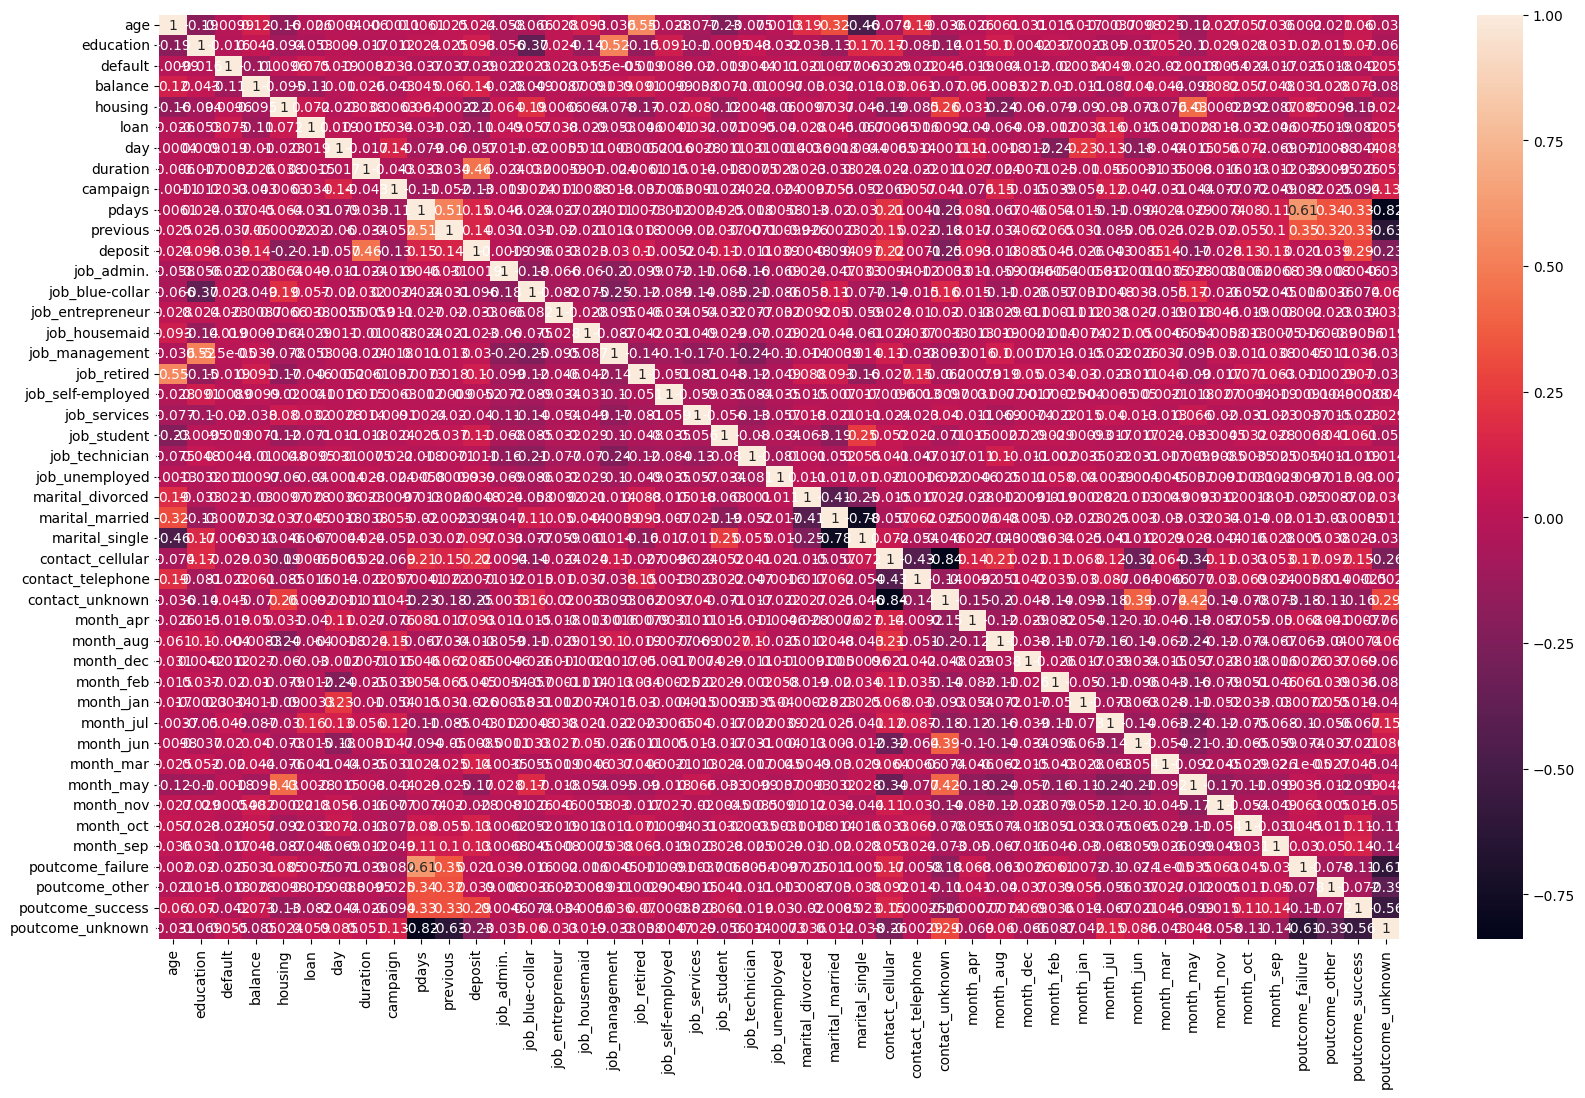

In [26]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Задания 7 и 8

In [27]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [28]:
# рассчитайте необходимые показатели

round(y_test.mean(), 2)

np.float64(0.46)

### Задание 9

In [29]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
kbest = SelectKBest(f_classif, k=15)
kbest.fit(X_train, y_train)

X_train = X_train[kbest.get_feature_names_out()]
X_test = X_test[kbest.get_feature_names_out()]

### Задание 10

In [30]:
# нормализуйте данные с помощью minmaxsxaler

minmax = MinMaxScaler()
X_train_scaled = minmax.fit_transform(X_train)
X_test_scaled = minmax.transform(X_test)

In [31]:
# Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки. Ответ округлите до двух знаков после точки-разделителя.

round(X_test_scaled[:, 0].mean(), 2)

np.float64(0.47)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [58]:

log_reg = linear_model.LogisticRegression(
    solver='sag', random_state=42, max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)
y_train_pred = log_reg.predict(X_train_scaled)

print(metrics.classification_report(y_train, y_train_pred))

y_test_pred = log_reg.predict(X_test_scaled)

print(metrics.classification_report(y_test, y_test_pred))
print('Test accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

Test accuracy: 0.80


In [48]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)1
print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335

0.8041979010494753


### Задания 2,3,4

In [51]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(random_state=42, criterion='entropy')
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)

print(f'confusion matrix: {metrics.confusion_matrix(y_test, y_pred)}')
print(f'classification report: {metrics.classification_report(y_test, y_pred)}')
print(f'accuracy score: {metrics.accuracy_score(y_test, y_pred)}')

y_train_pred = dt.predict(X_train_scaled)
print(f'train accuracy score: {metrics.classification_report(y_train, y_train_pred)}')

confusion matrix: [[1369  421]
 [ 401 1144]]
classification report:               precision    recall  f1-score   support

           0       0.77      0.76      0.77      1790
           1       0.73      0.74      0.74      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335

accuracy score: 0.7535232383808096
train accuracy score:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



### Задание 5

In [64]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
params_grid = {
    'max_depth': [int(x) for x in np.linspace(2,10, 5)]
}
grid = GridSearchCV(dt, params_grid, cv=5)
grid.fit(X_train_scaled, y_train)

y_pred = grid.best_estimator_.predict(X_test_scaled)

print(f'test classification report: {metrics.classification_report(y_test, y_pred)}')

y_train_pred = dt.predict(X_train_scaled)
print(f'train classification report: {metrics.classification_report(y_train, y_train_pred)}')

test classification report:               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

train classification report:               precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770



In [66]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
params_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
}
grid = GridSearchCV(dt, params_grid, cv=5 )
grid.fit(X_train_scaled, y_train)
y_pred = grid.best_estimator_.predict(X_test_scaled)

print(f'BEST PARAMS: {grid.best_params_}')
print(f'test classification report: {metrics.classification_report(y_test, y_pred)}')


BEST PARAMS: {'max_depth': 7, 'min_samples_split': 5}
test classification report:               precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.80      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [35]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [36]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [37]:
# объедините уже известные вам алгоритмы с помощью стекинга

### Задание 5

In [38]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [39]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna